In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [47]:
class LiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input_linear = nn.Linear(input_size, hidden_size)
        self.recurrent_linear = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.rand(hidden_size))  # Learnable time constants

    def forward(self, x, h):
        dx = -h + torch.tanh(self.input_linear(x) + self.recurrent_linear(h))
        h = h + dx * torch.sigmoid(self.tau)
        return h

class LiquidTimeConstantNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        super(LiquidTimeConstantNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.liquid_cell = LiquidCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.to(device)

    def forward(self, sequences):
        batch_size, seq_len, input_size = sequences.size()
        h = torch.zeros(batch_size, self.hidden_size, device=sequences.device)

        for t in range(seq_len):
            x_t = sequences[:, t, :]  # shape: (batch_size, input_size)
            h = self.liquid_cell(x_t, h)

        output = self.output_layer(h)  # shape: (batch_size, output_size)
        return output

    def predict(self, sequence):
        self.eval()
        with torch.no_grad():
            if isinstance(sequence, np.ndarray):
                sequence = torch.tensor(sequence, dtype=torch.float32).to(device)
            else:
                sequence = sequence.clone().detach().float().to(device)
    
            sequence = sequence.unsqueeze(0).to(device)  # add batch dim
            output = self.forward(sequence)
            return output.cpu().numpy().squeeze()


    def train_model(self, X, y, epochs=50):
        self.train()
        self.to(device)
    
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32).to(device)
        else:
            X = X.clone().detach().float().to(device)
    
        if isinstance(y, np.ndarray):
            y = torch.tensor(y, dtype=torch.float32).to(device)
        else:
            y = y.clone().detach().float().to(device)
    
        losses = []
    
        for epoch in range(epochs):
            self.optimizer.zero_grad()
    
            outputs = self(X)
    
            if outputs.shape != y.shape:
                try:
                    y = y.view_as(outputs)
                except RuntimeError:
                    print("Mismatch between output and target shape.")
                    print(f"Output shape: {outputs.shape}, Target shape: {y.shape}")
                    raise
    
            loss = self.criterion(outputs, y)
    
            loss.backward()
            self.optimizer.step()
    
            losses.append(loss.item())

        # if (epoch + 1) % 50 == 0 or epoch == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        return losses

In [48]:
def generate_synthetic_data_univariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data = np.sin(t) + noise_level * np.random.randn(seq_length)
    return data

def generate_synthetic_data_multivariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data1 = np.sin(t) + noise_level * np.random.randn(seq_length)
    data2 = np.cos(t) + noise_level * np.random.randn(seq_length)
    return np.column_stack([data1, data2])

In [49]:
seq_length = 100
data_univariate = generate_synthetic_data_univariate(seq_length)

scaler = MinMaxScaler()
data_univariate_scaled = scaler.fit_transform(data_univariate.reshape(-1, 1))
data_univariate = data_univariate_scaled

hidden_sizes = [20, 50, 100]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"\nTraining with Hidden={hidden_size}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                X_train_univariate_tuned = [data_univariate[i:i+window_size] for i in range(len(data_univariate) - window_size)]
                y_train_univariate_tuned = [data_univariate[i + window_size] for i in range(len(data_univariate) - window_size)]

                X_train_univariate_tuned = np.array(X_train_univariate_tuned).reshape(-1, window_size, 1)
                y_train_univariate_tuned = np.array(y_train_univariate_tuned).reshape(-1, 1)

                # Create and train model
                model = LiquidTimeConstantNetwork(input_size=1, hidden_size=hidden_size, output_size=1, learning_rate=learning_rate)
                model.to(device)
                
                # X_tensor = torch.tensor(X_train_univariate_tuned, dtype=torch.float32).to(device)
                # y_tensor = torch.tensor(y_train_univariate_tuned, dtype=torch.float32).to(device)
                model.train_model(X_tensor, y_tensor, epochs=epochs)

                
                # Predict on training set in batch
                X_train_tensor = torch.tensor(X_train_univariate_tuned, dtype=torch.float32).to(device)
                with torch.no_grad():
                    predictions_tensor = model(X_train_tensor)
                
                predictions = predictions_tensor.cpu().numpy().reshape(-1, 1)
                y_train_actual = scaler.inverse_transform(y_train_univariate_tuned)
                
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions))
                print(f"RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (hidden_size, learning_rate, epochs, window_size)

print("\nBest Hyperparameters:")
print(f"Hidden Size: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")


Training with Hidden=20, LR=0.01, Epochs=100, Window=5
RMSE: 0.5886

Training with Hidden=20, LR=0.01, Epochs=100, Window=10
RMSE: 0.5838

Training with Hidden=20, LR=0.01, Epochs=100, Window=15
RMSE: 0.6001

Training with Hidden=20, LR=0.01, Epochs=300, Window=5
RMSE: 0.5844

Training with Hidden=20, LR=0.01, Epochs=300, Window=10
RMSE: 0.5758

Training with Hidden=20, LR=0.01, Epochs=300, Window=15
RMSE: 0.6050

Training with Hidden=20, LR=0.01, Epochs=500, Window=5
RMSE: 0.6830

Training with Hidden=20, LR=0.01, Epochs=500, Window=10
RMSE: 0.5392

Training with Hidden=20, LR=0.01, Epochs=500, Window=15
RMSE: 0.6025

Training with Hidden=20, LR=0.005, Epochs=100, Window=5
RMSE: 0.7142

Training with Hidden=20, LR=0.005, Epochs=100, Window=10
RMSE: 0.5849

Training with Hidden=20, LR=0.005, Epochs=100, Window=15
RMSE: 0.6037

Training with Hidden=20, LR=0.005, Epochs=300, Window=5
RMSE: 0.6608

Training with Hidden=20, LR=0.005, Epochs=300, Window=10
RMSE: 0.5676

Training with Hidde

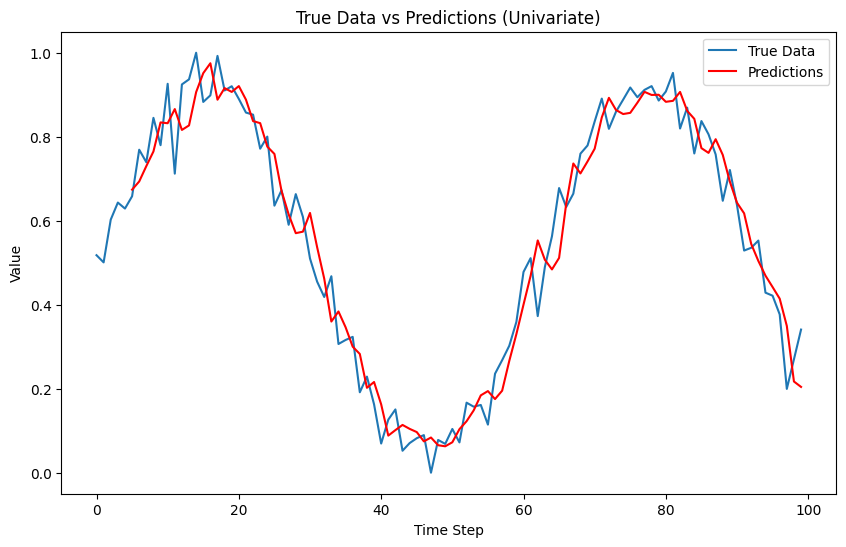

In [51]:
window_size = best_params[3]

# Create training sequences
X_train_univariate = [data_univariate[i:i+window_size] for i in range(len(data_univariate) - window_size)]
y_train_univariate = [data_univariate[i + window_size] for i in range(len(data_univariate) - window_size)]

# Reshape for PyTorch: (samples, time_steps, features)
X_train = np.array(X_train_univariate).reshape(-1, window_size, 1)
y_train = np.array(y_train_univariate).reshape(-1, 1)

# Create model (with GPU support)
model = LiquidTimeConstantNetwork(input_size=1, hidden_size=best_params[0], output_size=1, learning_rate=best_params[1])

# Convert training data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Train the model
model.train_model(X_train_tensor, y_train_tensor, epochs=best_params[2])

# Predict on training data (move each input to GPU)
predictions_univariate = []
for seq in X_train:
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
    pred = model.predict(seq_tensor)
    predictions_univariate.append(pred)
predictions_univariate = np.array(predictions_univariate).reshape(-1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_univariate, label="True Data")
plt.plot(range(window_size, seq_length), predictions_univariate, label="Predictions", color='red')
plt.legend()
plt.title('True Data vs Predictions (Univariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [52]:
data_multivariate = generate_synthetic_data_multivariate(seq_length)

# Scale multivariate data
scaler = MinMaxScaler()
data_multivariate_scaled = scaler.fit_transform(data_multivariate)
data_multivariate = data_multivariate_scaled

hidden_sizes = [20, 50, 100]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with Hidden={hidden_size}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Create windowed data
                X_train_multivariate_tuned = [data_multivariate[i:i+window_size] for i in range(len(data_multivariate) - window_size)]
                y_train_multivariate_tuned = [data_multivariate[i + window_size] for i in range(len(data_multivariate) - window_size)]

                # Reshape for PyTorch: (samples, time, features)
                X_train_multivariate_tuned = np.array(X_train_multivariate_tuned).reshape(-1, window_size, 2)
                y_train_multivariate_tuned = np.array(y_train_multivariate_tuned).reshape(-1, 2)

                # Create model on GPU
                model = LiquidTimeConstantNetwork(input_size=2, hidden_size=hidden_size, output_size=2, learning_rate=learning_rate)

                # Train model
                model.train_model(X_train_multivariate_tuned, y_train_multivariate_tuned, epochs=epochs)

                # Predict (move input to GPU, output to CPU)
                predictions = []
                for seq in X_train_multivariate_tuned:
                    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
                    pred = model.predict(seq_tensor)
                    predictions.append(pred)
                predictions = np.array(predictions).reshape(-1, 2)

                # Inverse transform to get original scale
                predictions = scaler.inverse_transform(predictions)
                y_train_actual = scaler.inverse_transform(y_train_multivariate_tuned)

                # Compute RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions))
                print(f"RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (hidden_size, learning_rate, epochs, window_size)

print("\nBest Hyperparameters for Multivariate Synthetic Data:")
print(f"Hidden Size: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with Hidden=20, LR=0.01, Epochs=100, Window=5
RMSE: 0.1152
Training with Hidden=20, LR=0.01, Epochs=100, Window=10
RMSE: 0.1125
Training with Hidden=20, LR=0.01, Epochs=100, Window=15
RMSE: 0.1158
Training with Hidden=20, LR=0.01, Epochs=300, Window=5
RMSE: 0.1048
Training with Hidden=20, LR=0.01, Epochs=300, Window=10
RMSE: 0.1058
Training with Hidden=20, LR=0.01, Epochs=300, Window=15
RMSE: 0.1070
Training with Hidden=20, LR=0.01, Epochs=500, Window=5
RMSE: 0.1075
Training with Hidden=20, LR=0.01, Epochs=500, Window=10
RMSE: 0.1025
Training with Hidden=20, LR=0.01, Epochs=500, Window=15
RMSE: 0.0952
Training with Hidden=20, LR=0.005, Epochs=100, Window=5
RMSE: 0.1119
Training with Hidden=20, LR=0.005, Epochs=100, Window=10
RMSE: 0.1143
Training with Hidden=20, LR=0.005, Epochs=100, Window=15
RMSE: 0.1116
Training with Hidden=20, LR=0.005, Epochs=300, Window=5
RMSE: 0.1076
Training with Hidden=20, LR=0.005, Epochs=300, Window=10
RMSE: 0.1090
Training with Hidden=20, LR=0.005,

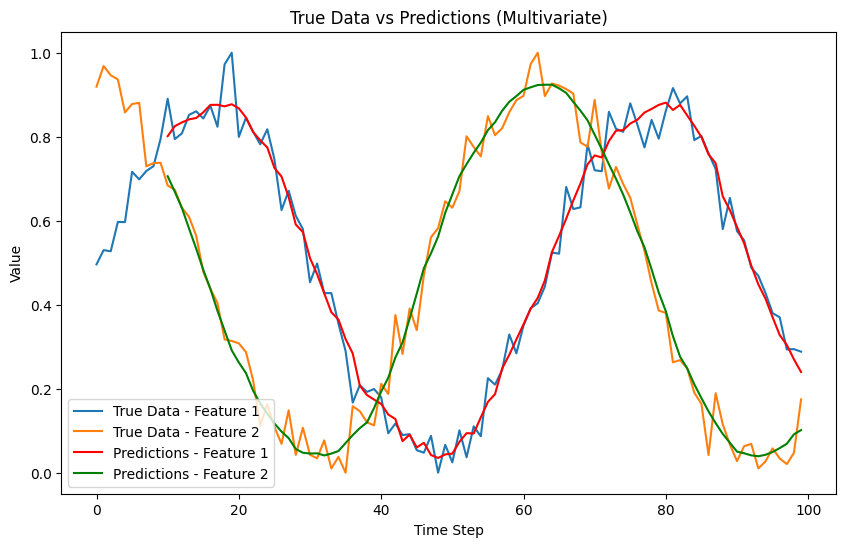

In [55]:
window_size = best_params[3]

# Prepare windowed sequences
X_train_multivariate = [data_multivariate[i:i+window_size] for i in range(len(data_multivariate) - window_size)]
y_train_multivariate = [data_multivariate[i + window_size] for i in range(len(data_multivariate) - window_size)]

# Reshape to (samples, time, features)
X_train = np.array(X_train_multivariate).reshape(-1, window_size, 2)
y_train = np.array(y_train_multivariate).reshape(-1, 2)

# Create and train the model (on GPU)
model = LiquidTimeConstantNetwork(input_size=2, hidden_size=best_params[0], output_size=2, learning_rate=best_params[1])

# Convert training data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

model.train_model(X_train, y_train, epochs=best_params[2])

# Predict (on GPU)
predictions_multivariate = []
for seq in X_train:
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
    pred = model.predict(seq_tensor)
    predictions_multivariate.append(pred)
predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 2)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_multivariate[:, 0], label="True Data - Feature 1")
plt.plot(range(seq_length), data_multivariate[:, 1], label="True Data - Feature 2")
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 0], label="Predictions - Feature 1", color='red')
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 1], label="Predictions - Feature 2", color='green')
plt.legend()
plt.title('True Data vs Predictions (Multivariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [56]:
df_tesla = pd.read_excel('/kaggle/input/data-stock/Tesla_Stock.xlsx')

df_tesla = df_tesla.drop(columns=["Unnamed: 0"], errors="ignore")

df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])
df_tesla.set_index("Date", inplace=True)

df_tesla = df_tesla[["Open", "Close"]]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_tesla)

df_scaled = pd.DataFrame(scaled_data, columns=df_tesla.columns, index=df_tesla.index)

df_scaled = df_scaled.iloc[-2000:]

df_scaled.head()

,Open,Close
Date,,
2016-02-04,0.004707,0.005272
2016-02-05,0.004806,0.003152
2016-02-08,0.002451,0.000719
2016-02-09,0.000000,0.000763
2016-02-10,0.001357,0.000000


In [57]:
# Splitting df_scaled into 80% training and 20% testing data

train_size = int(len(df_scaled) * 0.8)

df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 1600
Testing data size: 400


In [59]:
hidden_sizes = [20, 50, 100]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with Hidden={hidden_size}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Create windowed training data
                X_train_tesla_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_tesla_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

                X_train_tesla_tuned = np.array(X_train_tesla_tuned).astype(np.float32)  # (samples, window, features)
                y_train_tesla_tuned = np.array(y_train_tesla_tuned).astype(np.float32)  # (samples, features)

                # Initialize Liquid Time-Constant Network and move to GPU if available
                model = LiquidTimeConstantNetwork(input_size=2, hidden_size=hidden_size, output_size=2, learning_rate=learning_rate).to(device)

                # Move data to GPU if available
                X_train_tesla_tuned = torch.tensor(X_train_tesla_tuned).to(device)
                y_train_tesla_tuned = torch.tensor(y_train_tesla_tuned).to(device)

                # Train model
                model.train_model(X_train_tesla_tuned, y_train_tesla_tuned, epochs=epochs)

                # Predict
                predictions = [model.predict(seq.clone().detach()) for seq in X_train_tesla_tuned]
                predictions = np.array(predictions).reshape(-1, 2)
                

                # Inverse scale predictions and true labels
                predictions = scaler.inverse_transform(predictions)
                y_train_actual = scaler.inverse_transform(y_train_tesla_tuned.cpu().numpy())

                # Compute RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions))
                print(f"RMSE: {rmse:.4f}")

                # Save best model params
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (hidden_size, learning_rate, epochs, window_size)

print("\nBest Hyperparameters for Tesla Stock Data:")
print(f"Hidden Size: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with Hidden=20, LR=0.01, Epochs=100, Window=5
RMSE: 6.5988
Training with Hidden=20, LR=0.01, Epochs=100, Window=10
RMSE: 6.6404
Training with Hidden=20, LR=0.01, Epochs=100, Window=15
RMSE: 7.3299
Training with Hidden=20, LR=0.01, Epochs=300, Window=5
RMSE: 5.5516
Training with Hidden=20, LR=0.01, Epochs=300, Window=10
RMSE: 5.6085
Training with Hidden=20, LR=0.01, Epochs=300, Window=15
RMSE: 6.2272
Training with Hidden=20, LR=0.01, Epochs=500, Window=5
RMSE: 5.8258
Training with Hidden=20, LR=0.01, Epochs=500, Window=10
RMSE: 5.6915
Training with Hidden=20, LR=0.01, Epochs=500, Window=15
RMSE: 4.9075
Training with Hidden=20, LR=0.005, Epochs=100, Window=5
RMSE: 8.0964
Training with Hidden=20, LR=0.005, Epochs=100, Window=10
RMSE: 7.5709
Training with Hidden=20, LR=0.005, Epochs=100, Window=15
RMSE: 6.4408
Training with Hidden=20, LR=0.005, Epochs=300, Window=5
RMSE: 6.4782
Training with Hidden=20, LR=0.005, Epochs=300, Window=10
RMSE: 6.5759
Training with Hidden=20, LR=0.005,

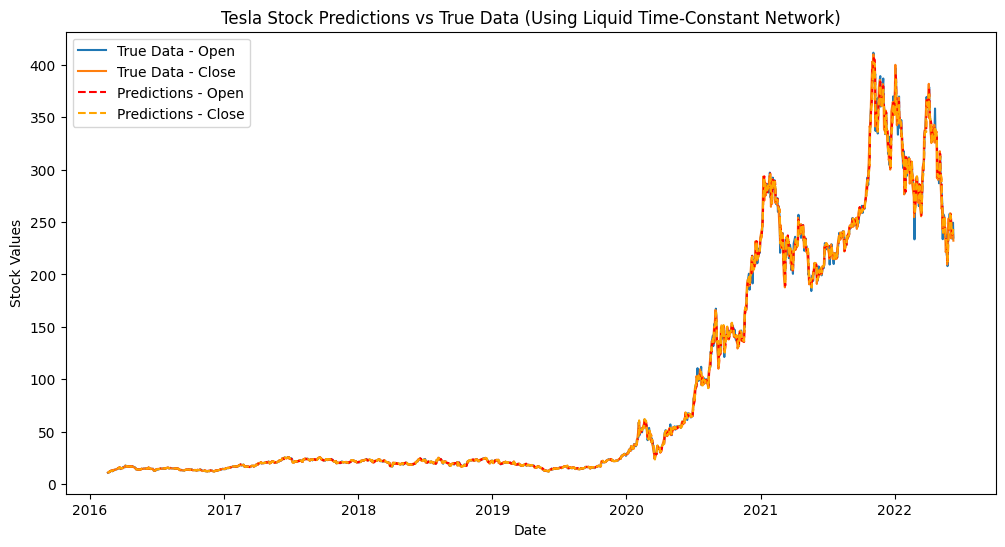

In [61]:
# Set window_size to the best parameter found
window_size = best_params[3]

# Create windowed training data
X_train_multivariate = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_multivariate = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_multivariate = np.array(X_train_multivariate).astype(np.float32)
y_train_multivariate = np.array(y_train_multivariate).astype(np.float32)

# Move data to the GPU if available
X_train_multivariate = torch.tensor(X_train_multivariate).to(device)
y_train_multivariate = torch.tensor(y_train_multivariate).to(device)

# Initialize Liquid model and move to GPU
ltc_model = LiquidTimeConstantNetwork(input_size=2, hidden_size=best_params[0], output_size=2, learning_rate=best_params[1]).to(device)

# Train the model
ltc_model.train_model(X_train_multivariate, y_train_multivariate, epochs=best_params[2])

# Generate predictions
predictions_multivariate = [ltc_model.predict(seq.clone().detach()) for seq in X_train_multivariate]
predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 2)

# Move predictions back to CPU for inverse transformation
# predictions_multivariate = predictions_multivariate.cpu().numpy()

# Inverse scale to original values
predictions_multivariate = scaler.inverse_transform(predictions_multivariate)
y_train_actual = scaler.inverse_transform(y_train_multivariate.cpu().numpy())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Open")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Close")
plt.plot(df_train.index[window_size:], predictions_multivariate[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_multivariate[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Using Liquid Time-Constant Network)')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

Test RMSE: 6.3994


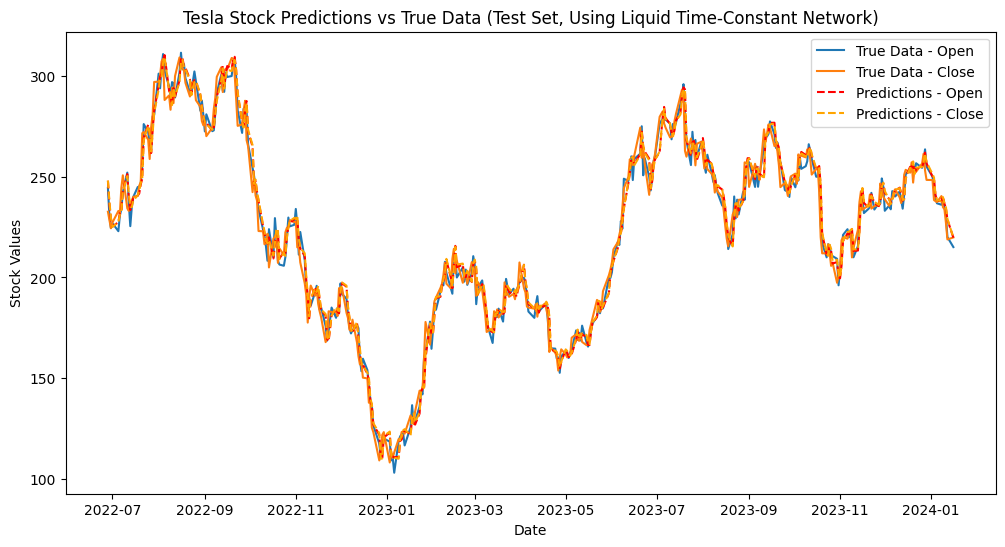

In [63]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# Move test data to the GPU if available
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

# Make predictions on test data using the trained Liquid model
predictions_test = [ltc_model.predict(seq.clone().detach()) for seq in X_test]
predictions_test = np.array(predictions_test).reshape(-1, 2)

# Move predictions back to CPU for inverse scaling
# predictions_test = predictions_test.cpu().numpy()

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test)
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Open")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Close")
plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Test Set, Using Liquid Time-Constant Network)')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

In [64]:
df_weather = pd.read_excel('/kaggle/input/data-weather/weatheraqDataset.xlsx')

df_weather = df_weather.drop(columns=["Unnamed: 0"], errors="ignore")

df_weather["date"] = pd.to_datetime(df_weather["date"])

df_weather.set_index("date", inplace=True)

df_weather = df_weather[["avg_nitrogen_dioxide", "max_nitrogen_dioxide"]]
df_weather = df_weather.iloc[-1500:]

# Check for missing values
if df_weather.isnull().any().any():
    print("Missing values detected, filling with forward fill method.")
    df_weather.fillna(method="ffill", inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_weather)

df_scaled = pd.DataFrame(scaled_data, columns=df_weather.columns, index=df_weather.index)

df_scaled.head()

,avg_nitrogen_dioxide,max_nitrogen_dioxide
date,,
2020-01-01,0.600210,0.506055
2020-01-02,0.684947,0.507785
2020-01-03,0.721895,0.598616
2020-01-04,0.585465,0.483564
2020-01-05,0.653535,0.631488


In [65]:
# Splitting df_scaled into 80% training and 20% testing data
train_size = int(len(df_scaled) * 0.8)

df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

# Checking the sizes of training and testing sets
print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 1168
Testing data size: 293


In [66]:
hidden_sizes = [20, 50, 100]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with Hidden={hidden_size}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Prepare sequences
                X_train_aq_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_aq_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

                X_train_aq_tuned = np.array(X_train_aq_tuned)
                y_train_aq_tuned = np.array(y_train_aq_tuned)

                # Convert to PyTorch tensors and move to GPU
                X_train_aq_tuned = torch.tensor(X_train_aq_tuned).float().to(device)
                y_train_aq_tuned = torch.tensor(y_train_aq_tuned).float().to(device)

                # Initialize LTC model and move it to GPU
                ltc_model = LiquidTimeConstantNetwork(input_size=2, hidden_size=hidden_size, output_size=2, learning_rate=learning_rate)
                ltc_model.to(device)

                # Train the model
                ltc_model.train_model(X_train_aq_tuned, y_train_aq_tuned, epochs=epochs)

                # Generate predictions
                predictions = [ltc_model.predict(X_seq) for X_seq in X_train_aq_tuned]
                predictions = np.array(predictions).reshape(-1, 2)

                # Reverse scaling
                predictions = scaler.inverse_transform(predictions)
                y_train_actual = scaler.inverse_transform(y_train_aq_tuned.cpu().numpy())  # Move to CPU for inverse scaling

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions))
                print(f"RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (hidden_size, learning_rate, epochs, window_size)

print("\nBest Hyperparameters for Air Data using Liquid Time-Constant Network:")
print(f"Hidden Size: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with Hidden=20, LR=0.01, Epochs=100, Window=5
RMSE: 8.8658
Training with Hidden=20, LR=0.01, Epochs=100, Window=10
RMSE: 8.7562
Training with Hidden=20, LR=0.01, Epochs=100, Window=15
RMSE: 8.8151
Training with Hidden=20, LR=0.01, Epochs=300, Window=5
RMSE: 8.7485
Training with Hidden=20, LR=0.01, Epochs=300, Window=10
RMSE: 8.5682
Training with Hidden=20, LR=0.01, Epochs=300, Window=15
RMSE: 8.5080
Training with Hidden=20, LR=0.01, Epochs=500, Window=5
RMSE: 8.6729
Training with Hidden=20, LR=0.01, Epochs=500, Window=10
RMSE: 8.5598
Training with Hidden=20, LR=0.01, Epochs=500, Window=15
RMSE: 8.5397
Training with Hidden=20, LR=0.005, Epochs=100, Window=5
RMSE: 9.3755
Training with Hidden=20, LR=0.005, Epochs=100, Window=10
RMSE: 9.1466
Training with Hidden=20, LR=0.005, Epochs=100, Window=15
RMSE: 9.1405
Training with Hidden=20, LR=0.005, Epochs=300, Window=5
RMSE: 8.9211
Training with Hidden=20, LR=0.005, Epochs=300, Window=10
RMSE: 8.6893
Training with Hidden=20, LR=0.005,

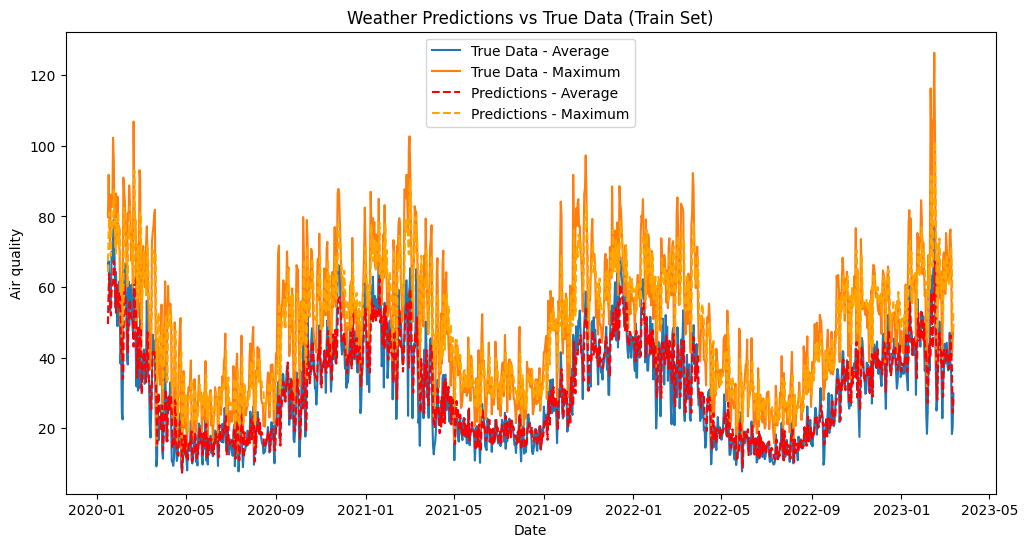

In [67]:
# Set window size
window_size = best_params[3] 

# Prepare training data using the same window size
X_train_multivariate = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_multivariate = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_multivariate = np.array(X_train_multivariate)
y_train_multivariate = np.array(y_train_multivariate)

# Move training data to GPU
X_train_multivariate = torch.tensor(X_train_multivariate).float().to(device)
y_train_multivariate = torch.tensor(y_train_multivariate).float().to(device)

# Initialize Liquid Time-Constant Network (LTC) model
ltc_multivariate = LiquidTimeConstantNetwork(input_size=2, hidden_size=best_params[0], output_size=2, learning_rate=best_params[1])
ltc_multivariate.to(device)

# Train the model
ltc_multivariate.train_model(X_train_multivariate, y_train_multivariate, epochs=best_params[2])

# Make predictions on training data using the trained model
predictions_train_multivariate = [ltc_multivariate.predict(X_window) for X_window in X_train_multivariate]
predictions_train_multivariate = np.array(predictions_train_multivariate).reshape(-1, 2)

# Reverse scaling to get original values
predictions_train_multivariate = scaler.inverse_transform(predictions_train_multivariate)
y_train_actual = scaler.inverse_transform(y_train_multivariate.cpu().numpy())  # Move to CPU for inverse scaling

# Plotting Train Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Average")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Maximum")

plt.plot(df_train.index[window_size:], predictions_train_multivariate[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_train_multivariate[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

plt.legend()
plt.title('Weather Predictions vs True Data (Train Set)')
plt.xlabel('Date')
plt.ylabel('Air quality')
plt.show()

# # Prepare test data using the same window size
# X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
# y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # Move test data to GPU
# X_test = torch.tensor(X_test).float().to(device)
# y_test = torch.tensor(y_test).float().to(device)

# # Make predictions on test data using the trained model
# predictions_test = [ltc_multivariate.predict(X_window) for X_window in X_test]
# predictions_test = np.array(predictions_test).reshape(-1, 2)

# # Reverse scaling to get original values
# predictions_test = scaler.inverse_transform(predictions_test)
# y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())  # Move to CPU for inverse scaling

# # Calculate RMSE for test data
# rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
# print(f"Test RMSE: {rmse_test:.4f}")

# # Plotting Test Predictions vs Actuals
# plt.figure(figsize=(12, 6))
# plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Average")
# plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Maximum")

# plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
# plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

# plt.legend()
# plt.title('Weather Predictions vs True Data (Test Set)')
# plt.xlabel('Date')
# plt.ylabel('Air quality')
# plt.show()

Test RMSE: 7.7186


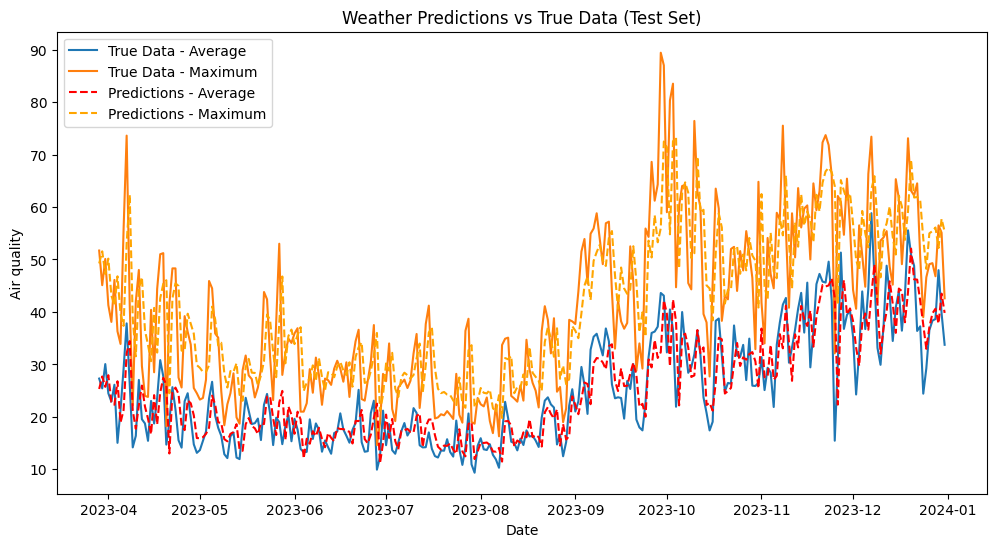

In [68]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test)
y_test = np.array(y_test)

# Move test data to GPU
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

# Make predictions on test data using the trained model
predictions_test = [ltc_multivariate.predict(X_window) for X_window in X_test]
predictions_test = np.array(predictions_test).reshape(-1, 2)

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test)
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())  # Move to CPU for inverse scaling

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plotting Test Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Average")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Maximum")

plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

plt.legend()
plt.title('Weather Predictions vs True Data (Test Set)')
plt.xlabel('Date')
plt.ylabel('Air quality')
plt.show()